In [3]:
import ee
import geopandas as gpd
from src.data import gedi_pipeline
from src.data.ee import lcms_import
from src.processing.regen import regen_analysis
from src.data.ee import ee_utils
from src.data.fire_perimeters import FirePerimeters, FirePerimetersDB, Fire, match_gedi_to_raster, FireRastersDB
from src.data import fire_perimeters
from src.data import gedi_raster_matching
from src.data import raster
from src.processing.control import random_control
import rasterio as rio
import matplotlib.pyplot as plt
import pandas as pd
from src.constants import DATA_PATH, USER_PATH
from fitter import Fitter, get_common_distributions, get_distributions
import seaborn as sns
from src.processing.control import random_control, eval, nearest, terrain_clustering, rf_control
from src.data import k_nn
from src.data import clustering
import numpy as np
from fastai.tabular.all import load_pickle
import pickle

import importlib
importlib.reload(regen_analysis)
importlib.reload(gedi_pipeline)
importlib.reload(ee_utils)
importlib.reload(gedi_raster_matching)
importlib.reload(raster)
importlib.reload(fire_perimeters)
importlib.reload(random_control)
importlib.reload(eval)
importlib.reload(terrain_clustering)
importlib.reload(k_nn)
importlib.reload(clustering)
importlib.reload(rf_control)

2023-06-24 21:44:05,556 DEBUG: Logger /home/jk871/fire-regen/src/data/gedi_pipeline.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]
2023-06-24 21:44:05,557 DEBUG: Logger /home/jk871/fire-regen/src/data/ee/ee_utils.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]
2023-06-24 21:44:05,557 DEBUG: Logger /home/jk871/fire-regen/src/data/gedi_raster_matching.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]
2023-06-24 21:44:05,558 DEBUG: Logger /home/jk871/fire-regen/src/data/fire_perimeters.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]


<module 'src.processing.control.rf_control' from '/home/jk871/fire-regen/src/processing/control/rf_control.py'>

In [4]:
sierras = gpd.read_file(f"{USER_PATH}/data/shapefiles/sierras_convex_hull.shp")
sierras_3310 = sierras.to_crs(epsg=3310)

In [5]:
gedi_burned, gedi_unburned = gedi_pipeline.load_stage_9(3)

In [6]:
gedi_unburned_3310 = gedi_unburned.to_crs(epsg=3310)

In [7]:
def print_errors(errors):
    print("Mean Errors:")
    print(errors[:, 0].mean())
    print(errors[:, 1].mean())

    print("Median Errors:")
    print(errors[:, 2].mean())
    print(errors[:, 3].mean())

In [8]:
def plot_errors(errors):
    fig, ax = plt.subplots(2, 2, figsize=(5, 5))
    sns.histplot(errors[:, 0], ax=ax[0][0])
    sns.histplot(errors[:, 1], ax=ax[0][1])
    sns.histplot(errors[:, 2], ax=ax[1][0])
    sns.histplot(errors[:, 3], ax=ax[1][1])

### Algo 5 - RFs

In [ ]:
# Choose only the ones chosen by RF
columns_to_cluster = ['SR_B7', 'SR_B6', 'SR_B4', 'elevation', 'aspect']
errors = None
for i in range(20):
    new_errors = eval.evaluate_control(5, gedi_single_year, 5000, 200, 
    lambda x, y, z, t: terrain_clustering.match_with_nearest_shot_from_terrain_cluster(x, y, z, t, 10, columns_to_cluster))
    if errors is None:
        errors = new_errors
    else:
        errors = np.vstack((errors, new_errors))

print_errors(errors)
plot_errors(errors)

In [17]:
gedi_3310 = gedi.to_crs(epsg=3310)

In [108]:
year = 2012

In [113]:
gedi = load_pickle(f"{DATA_PATH}/rf/gedi_match_{year}.pkl")

In [114]:
m = load_pickle(f"{DATA_PATH}/rf/models/model_{year}.pkl")

In [115]:
to = pickle.load(open(f"{DATA_PATH}/rf/models/to_{year}.pkl", 'rb'))
lala = to.train.new(gedi.head(100))
lala.process()

In [116]:
eval.evaluate_control(1, gedi, 1, 1, lambda x, y, z, t: rf_control.match_with_rf_synthetic_estimate(x, y, z, t, year), crs=4326)

matching shots within fire
Processing data
Run prediction
[ 32.33675255  34.13341325  42.06659673  33.17751152  28.15639486
  31.00710717  37.04453433  32.77394915  29.60297881  27.77421091
  22.21608474  21.77932899  20.08282417  63.21353213  46.44216179
  17.64964299  16.5749838   50.26388516  37.74305674  39.19949358
  45.96091092  42.37078596  20.27308155  44.13049663  39.87188656
  45.24139477  21.69089573  21.02827972 111.02963554  80.75545939
  76.48309384  71.99569476  63.29574805  69.42562525  68.06484718
  92.72052485 110.58805923  67.64904244 104.18966839  84.65960459
  77.66096706  79.5822665   73.76098677  65.77075816  74.10188747
  84.97230287  89.21653433  88.93765798  63.10646792  32.50339667
  50.2131879   53.03582681  44.82186379  26.91520553  22.51127618
  23.05766076  28.56694915  46.04329589  27.4883738   26.67163722
  50.37969258  31.41349064  27.1177385   26.60126972  33.07407598
  46.92539632  48.71727196  46.50837529  31.0096482   27.26356743
  24.49165959  23.

AttributeError: 'NoneType' object has no attribute 'agbd'

In [67]:
m.feature_names_in_

array(['SR_B1_1985_na', 'SR_B1_1986_na', 'SR_B1_1987_na', 'SR_B1_1988_na',
       'SR_B1_1989_na', 'SR_B2_1985_na', 'SR_B2_1986_na', 'SR_B2_1987_na',
       'SR_B2_1988_na', 'SR_B2_1989_na', 'SR_B3_1985_na', 'SR_B3_1986_na',
       'SR_B3_1987_na', 'SR_B3_1988_na', 'SR_B3_1989_na', 'SR_B4_1985_na',
       'SR_B4_1986_na', 'SR_B4_1987_na', 'SR_B4_1988_na', 'SR_B4_1989_na',
       'SR_B5_1985_na', 'SR_B5_1986_na', 'SR_B5_1987_na', 'SR_B5_1988_na',
       'SR_B5_1989_na', 'SR_B7_1985_na', 'SR_B7_1986_na', 'SR_B7_1987_na',
       'SR_B7_1988_na', 'SR_B7_1989_na', 'NDVI_1985_na', 'NDVI_1986_na',
       'NDVI_1987_na', 'NDVI_1988_na', 'NDVI_1989_na', 'pft_class',
       'elevation', 'slope', 'aspect', 'soil', 'gedi_year', 'SR_B1_1985',
       'SR_B1_1986', 'SR_B1_1987', 'SR_B1_1988', 'SR_B1_1989',
       'SR_B2_1985', 'SR_B2_1986', 'SR_B2_1987', 'SR_B2_1988',
       'SR_B2_1989', 'SR_B3_1985', 'SR_B3_1986', 'SR_B3_1987',
       'SR_B3_1988', 'SR_B3_1989', 'SR_B4_1985', 'SR_B4_1986',
       '

In [69]:
lala.train.xs.columns

Index(['SR_B1_1985_na', 'SR_B2_1985_na', 'SR_B3_1985_na', 'SR_B4_1985_na',
       'SR_B5_1985_na', 'SR_B7_1985_na', 'NDVI_1985_na', 'SR_B1_1986_na',
       'SR_B2_1986_na', 'SR_B3_1986_na', 'SR_B4_1986_na', 'SR_B5_1986_na',
       'SR_B7_1986_na', 'NDVI_1986_na', 'SR_B1_1987_na', 'SR_B2_1987_na',
       'SR_B3_1987_na', 'SR_B4_1987_na', 'SR_B5_1987_na', 'SR_B7_1987_na',
       'NDVI_1987_na', 'SR_B1_1988_na', 'SR_B2_1988_na', 'SR_B3_1988_na',
       'SR_B4_1988_na', 'SR_B5_1988_na', 'SR_B7_1988_na', 'NDVI_1988_na',
       'SR_B1_1989_na', 'SR_B2_1989_na', 'SR_B3_1989_na', 'SR_B4_1989_na',
       'SR_B5_1989_na', 'SR_B7_1989_na', 'NDVI_1989_na', 'pft_class',
       'elevation', 'slope', 'aspect', 'soil', 'gedi_year', 'SR_B1_1985',
       'SR_B2_1985', 'SR_B3_1985', 'SR_B4_1985', 'SR_B5_1985', 'SR_B7_1985',
       'NDVI_1985', 'SR_B1_1986', 'SR_B2_1986', 'SR_B3_1986', 'SR_B4_1986',
       'SR_B5_1986', 'SR_B7_1986', 'NDVI_1986', 'SR_B1_1987', 'SR_B2_1987',
       'SR_B3_1987', 'SR_B4_198

In [70]:
eval.evaluate_control(1, gedi, 1, 1, lambda x, y, z, t: rf_control.match_with_rf_synthetic_estimate(x, y, z, t, 1989), crs=4326)

matching shots within fire
Processing data


KeyError: "['SR_B1_1984', 'SR_B2_1984', 'SR_B3_1984', 'SR_B4_1984', 'SR_B5_1984', 'SR_B7_1984', 'NDVI_1984'] not in index"

matching shots within fire
Processing data
Run prediction
matching shots within fire
Processing data
Run prediction
matching shots within fire
Processing data
Run prediction
matching shots within fire
Processing data
Run prediction
matching shots within fire
Processing data
Run prediction
matching shots within fire
Processing data
Run prediction
matching shots within fire
Processing data
Run prediction
matching shots within fire
Processing data
Run prediction
matching shots within fire
Processing data
Run prediction
matching shots within fire
Processing data
Run prediction
matching shots within fire
Processing data
Run prediction
matching shots within fire
Processing data
Run prediction
matching shots within fire
Processing data
Run prediction
matching shots within fire
Processing data
Run prediction
matching shots within fire
Processing data
Run prediction
matching shots within fire
Processing data
Run prediction
matching shots within fire
Processing data
Run prediction
matching shots

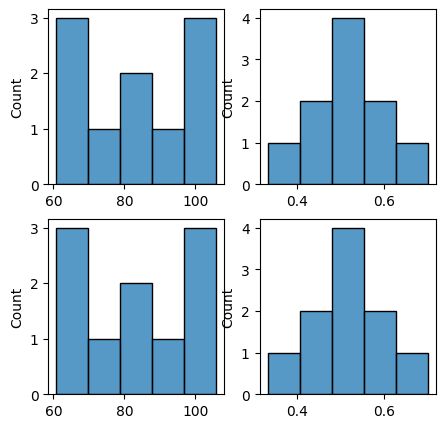

In [31]:
errors = None
for i in range(10):
    new_errors = eval.evaluate_control(5, gedi_3310, 1, 1, lambda x, y, z, t: rf_control.match_with_rf_synthetic_estimate(x, y, z, t, 2019))
    if errors is None:
        errors = new_errors
    else:
        errors = np.vstack((errors, new_errors))

print_errors(errors)
plot_errors(errors)

matching shots within fire
Processing data
Run prediction
matching shots within fire
Processing data
Run prediction
matching shots within fire
Processing data
Run prediction
matching shots within fire
Processing data
Run prediction
matching shots within fire
Processing data
Run prediction
matching shots within fire
Processing data
Run prediction
matching shots within fire
Processing data
Run prediction
matching shots within fire
Processing data
Run prediction
matching shots within fire
Processing data
Run prediction
matching shots within fire
Processing data
Run prediction
matching shots within fire
Processing data
Run prediction
matching shots within fire
Processing data
Run prediction
matching shots within fire
Processing data
Run prediction
matching shots within fire
Processing data
Run prediction
matching shots within fire
Processing data
Run prediction
matching shots within fire
Processing data
Run prediction
matching shots within fire
Processing data
Run prediction
matching shots

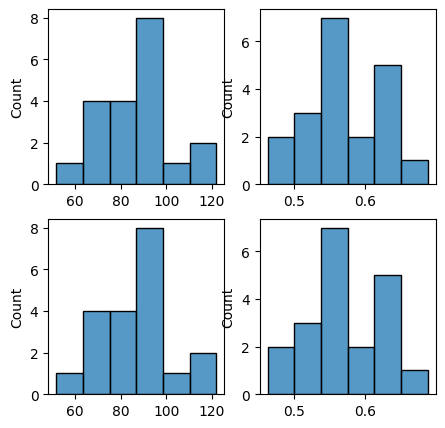

In [32]:
errors = None
for i in range(20):
    new_errors = eval.evaluate_control(5, gedi_3310, 1, 1, lambda x, y, z, t: rf_control.match_with_rf_synthetic_estimate(x, y, z, t, 2019))
    if errors is None:
        errors = new_errors
    else:
        errors = np.vstack((errors, new_errors))

print_errors(errors)
plot_errors(errors)

## Evaluate Algo 4 - Spectral clustering

In [3]:
landsat_2018 = raster.RasterSampler(raster.LANDSAT_RASTER(2018), raster.LANDSAT_BANDS)
landsat_2019 = raster.RasterSampler(raster.LANDSAT_RASTER(2019), raster.LANDSAT_BANDS)
landsat_2020 = raster.RasterSampler(raster.LANDSAT_RASTER(2020), raster.LANDSAT_BANDS)
landsat_2021 = raster.RasterSampler(raster.LANDSAT_RASTER(2021), raster.LANDSAT_BANDS)

In [4]:
gedi_unburned_2018 = landsat_2018.sample_3x3(gedi_unburned, 'longitude', 'latitude')

In [5]:
spectral = ["SR_B1", "SR_B2", "SR_B3", "SR_B4", "SR_B5", "SR_B6", "SR_B7", "ndvi", "nbr"]

In [6]:
gedi_unburned_2018.rename(columns=dict(zip([f"{x}_mean" for x in spectral], [f"{x}_2018" for x in spectral])), inplace=True)

In [9]:
def drop_spectral_columns(df):
    return df.drop(columns=['nbr_3x3',
       'nbr_median', 'nbr_std', 'ndvi_3x3', 'ndvi_median', 'ndvi_std',
        'SR_B1_3x3', 'SR_B1_median', 'SR_B1_std', 
       'SR_B2_3x3', 'SR_B2_median', 'SR_B2_std',  'SR_B3_3x3',
       'SR_B3_median', 'SR_B3_std',  'SR_B4_3x3', 'SR_B4_median',
       'SR_B4_std', 'SR_B5_3x3', 'SR_B5_median', 'SR_B5_std',
        'SR_B6_3x3', 'SR_B6_median', 'SR_B6_std', 
       'SR_B7_3x3', 'SR_B7_median', 'SR_B7_std'])

In [10]:
gedi_unburned_2018 = drop_spectral_columns(gedi_unburned_2018)

In [11]:
gedi_unburned_2019 = landsat_2019.sample_3x3(gedi_unburned_2018, 'longitude', 'latitude')

In [12]:
gedi_unburned_2019.rename(columns=dict(zip([f"{x}_mean" for x in spectral], [f"{x}_2019" for x in spectral])), inplace=True)
gedi_unburned_2019 = drop_spectral_columns(gedi_unburned_2019)

In [28]:
gedi_unburned_2020= landsat_2020.sample_3x3(gedi_unburned_2019, 'longitude', 'latitude')

In [29]:
gedi_unburned_2020.rename(columns=dict(zip([f"{x}_mean" for x in spectral], [f"{x}_2020" for x in spectral])), inplace=True)
gedi_unburned_2020 = drop_spectral_columns(gedi_unburned_2020)

In [30]:
gedi_unburned_2021= landsat_2021.sample_3x3(gedi_unburned_2020, 'longitude', 'latitude')

In [31]:
gedi_unburned_2021.rename(columns=dict(zip([f"{x}_mean" for x in spectral], [f"{x}_2021" for x in spectral])), inplace=True)
gedi_unburned_2021= drop_spectral_columns(gedi_unburned_2021)

In [32]:
gedi_unburned_ls_3310 = gedi_unburned_2021.to_crs(epsg=3310)

In [50]:
gedi_unburned_ls_3310 = gedi_unburned_ls_3310.dropna(subset=["ndvi_2018", "ndvi_2019", "ndvi_2020", "ndvi_2021"])

In [ ]:
gedi_unburned_ls_3310.to_csv(f"{DATA_PATH}/sierras_unburned_spectral_control_clustering_input.csv")

In [3]:
gedi_unburned_ls_3310 = gedi_pipeline.get_gedi_as_gdp(f"{DATA_PATH}/sierras_unburned_spectral_control_clustering_input.csv")

In [7]:
gedi_unburned_ls_3310 = gedi_unburned_ls_3310.to_crs(epsg=3310)

### Selected Spectral Single Year

In [12]:
gedi_2019 = gedi_unburned_ls_3310[gedi_unburned_ls_3310.gedi_year == 2019]
gedi_2020 = gedi_unburned_ls_3310[gedi_unburned_ls_3310.gedi_year == 2020]
gedi_2021 = gedi_unburned_ls_3310[gedi_unburned_ls_3310.gedi_year == 2021]
gedi_2022 = gedi_unburned_ls_3310[gedi_unburned_ls_3310.gedi_year == 2022]

In [14]:
spectral = ["SR_B1", "SR_B2", "SR_B3", "SR_B4", "SR_B5", "SR_B6", "SR_B7", "ndvi", "nbr"]
gedi_2019 = gedi_2019.rename(columns=dict(zip([f"{x}_2018" for x in spectral], [x for x in spectral])))
gedi_2020 = gedi_2020.rename(columns=dict(zip([f"{x}_2019" for x in spectral], [x for x in spectral])))
gedi_2021 = gedi_2021.rename(columns=dict(zip([f"{x}_2020" for x in spectral], [x for x in spectral])))
gedi_2022 = gedi_2022.rename(columns=dict(zip([f"{x}_2021" for x in spectral], [x for x in spectral])))

In [15]:
gedi_single_year = pd.concat([gedi_2019, gedi_2020, gedi_2021, gedi_2022])

Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
9
Enter clusteing knn
9
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
9
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
9
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
9
Enter clusteing knn
10
Enter clusteing knn
9
Enter clusteing knn
8
Enter clusteing knn
10
Enter clusteing knn
7
Enter clusteing knn
10
Enter clusteing knn
9
Enter clusteing knn
10
Enter clusteing knn
9
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
9
Enter clusteing knn
9
Enter clusteing knn
10
Enter clusteing knn
9
Enter clusteing knn
10
Enter clusteing knn
9
En

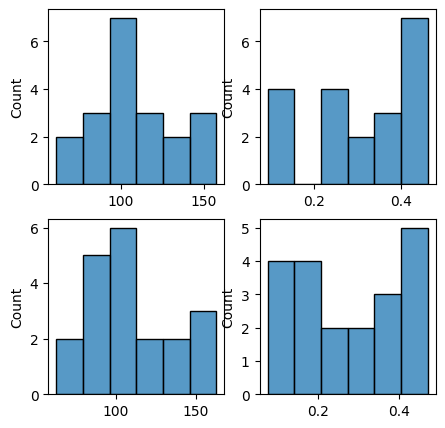

In [17]:
# Choose only the ones chosen by RF
columns_to_cluster = ['SR_B7', 'SR_B6', 'SR_B4', 'elevation', 'aspect']
errors = None
for i in range(20):
    new_errors = eval.evaluate_control(5, gedi_single_year, 5000, 200, 
    lambda x, y, z, t: terrain_clustering.match_with_nearest_shot_from_terrain_cluster(x, y, z, t, 10, columns_to_cluster))
    if errors is None:
        errors = new_errors
    else:
        errors = np.vstack((errors, new_errors))

print_errors(errors)
plot_errors(errors)

Enter clusteing knn
8
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
9
Enter clusteing knn
9
Enter clusteing knn
9
Enter clusteing knn
10
Enter clusteing knn
9
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
9
Enter clusteing knn
10
Enter clusteing knn
8
Enter clusteing knn
10
Enter clusteing knn
9
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
9
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
9
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
8
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
7
Enter clusteing knn
9
Enter clusteing knn
10
E

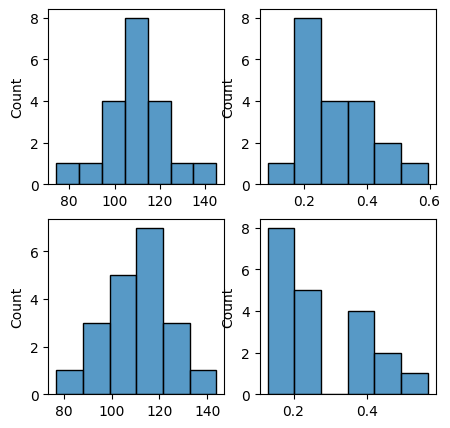

In [18]:
# Choose only the ones chosen by RF
columns_to_cluster = ['SR_B7', 'SR_B6', 'SR_B4', 'elevation', 'aspect', 'slope']
errors = None
for i in range(20):
    new_errors = eval.evaluate_control(5, gedi_single_year, 5000, 200, 
    lambda x, y, z, t: terrain_clustering.match_with_nearest_shot_from_terrain_cluster(x, y, z, t, 10, columns_to_cluster))
    if errors is None:
        errors = new_errors
    else:
        errors = np.vstack((errors, new_errors))

print_errors(errors)
plot_errors(errors)

In [ ]:
# Choose only the ones chosen by RF
columns_to_cluster = ['SR_B7', 'SR_B6', 'SR_B4', 'elevation', 'aspect', 'slope']
errors = None
for i in range(20):
    new_errors = eval.evaluate_control(5, gedi_single_year, 5000, 200, 
    lambda x, y, z, t: terrain_clustering.match_with_nearest_shot_from_terrain_cluster(x, y, z, t, 10, columns_to_cluster))
    if errors is None:
        errors = new_errors
    else:
        errors = np.vstack((errors, new_errors))

print_errors(errors)
plot_errors(errors)

### Selected Spectral

In [8]:
# Choose only the ones chosen by RF
columns_to_cluster = ['SR_B7_2020', 'SR_B7_2019', 'SR_B4_2019', 'SR_B4_2020', 'aspect', 'elevation', 'slope', 'SR_B6_2020', 'SR_B3_2019', 'SR_B7_2021']
errors = None
for i in range(20):
    new_errors = eval.evaluate_control(5, gedi_unburned_ls_3310, 5000, 200, 
    lambda x, y, z, t: terrain_clustering.match_with_nearest_shot_from_terrain_cluster(x, y, z, t, 10, columns_to_cluster))
    if errors is None:
        errors = new_errors
    else:
        errors = np.vstack((errors, new_errors))

print_errors(errors)
plot_errors(errors)

Enter clusteing knn
9
Enter clusteing knn
9
Enter clusteing knn
10
Enter clusteing knn
8
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
9
Enter clusteing knn
10
Enter clusteing knn
8
Enter clusteing knn
10
Enter clusteing knn
6
Enter clusteing knn
7
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
9
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
6
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
9
Enter clusteing knn
9
Enter clusteing knn
10
Enter clusteing knn
9
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
5
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
9
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
9
Ent

NameError: name 'print_errors' is not defined

Mean Errors:
94.95327101026837
0.3750799414736596
Median Errors:
96.55024868922587
0.3517694112906945


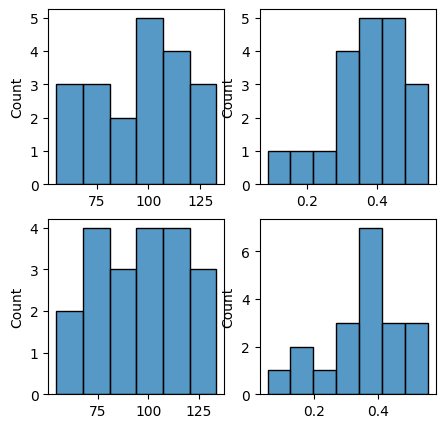

In [11]:
print_errors(errors)
plot_errors(errors)

### All spectral

Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
9
Enter clusteing knn
7
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
8
Enter clusteing knn
9
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
9
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
9
Enter clusteing knn
7
Enter clusteing knn
9
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
8
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
8
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
1

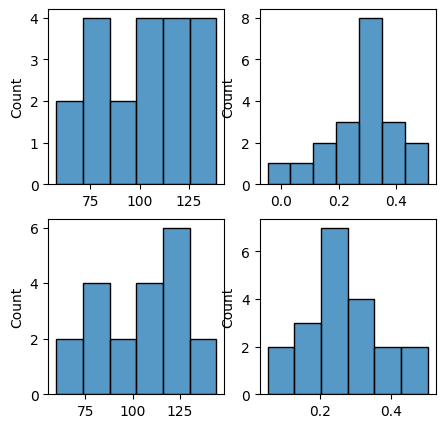

In [55]:
columns_to_cluster = [f"{x}_2018" for x in spectral] + [f"{x}_2019" for x in spectral] + [f"{x}_2020" for x in spectral] + [f"{x}_2021" for x in spectral]
errors = None
for i in range(20):
    new_errors = eval.evaluate_control(5, gedi_unburned_ls_3310, 5000, 200, 
    lambda x, y, z, t: terrain_clustering.match_with_nearest_shot_from_terrain_cluster(x, y, z, t, 10, columns_to_cluster))
    if errors is None:
        errors = new_errors
    else:
        errors = np.vstack((errors, new_errors))

print_errors(errors)
plot_errors(errors)

Enter clusteing knn
9
Enter clusteing knn
10
Enter clusteing knn
9
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
9
Enter clusteing knn
9
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
9
Enter clusteing knn
9
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
7
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
1
Enter clusteing knn
9
Enter clusteing knn
10
Enter clusteing knn
6
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
1

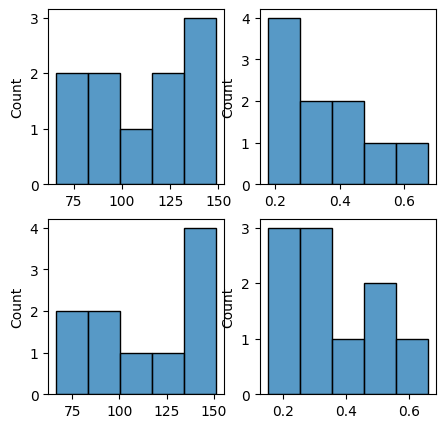

In [54]:
columns_to_cluster = [f"{x}_2018" for x in spectral] + [f"{x}_2019" for x in spectral] + [f"{x}_2020" for x in spectral] + [f"{x}_2021" for x in spectral]
errors = None
for i in range(10):
    new_errors = eval.evaluate_control(5, gedi_unburned_ls_3310, 5000, 200, 
    lambda x, y, z, t: terrain_clustering.match_with_nearest_shot_from_terrain_cluster(x, y, z, t, 10, columns_to_cluster))
    if errors is None:
        errors = new_errors
    else:
        errors = np.vstack((errors, new_errors))

print_errors(errors)
plot_errors(errors)

### NDVI clustering

Enter clusteing knn
8
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
9
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
8
Enter clusteing knn
10
Enter clusteing knn
7
Enter clusteing knn
5
Enter clusteing knn
10
Enter clusteing knn
7
Enter clusteing knn
10
Enter clusteing knn
9
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
5
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
9
Enter clusteing knn
10
Enter clusteing knn
8
Enter clusteing knn
7
Enter clusteing knn
8
Enter clusteing knn
9
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
9
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
9
Enter clusteing knn
10
Enter clusteing knn
6
Enter clusteing knn
8
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
10
Enter

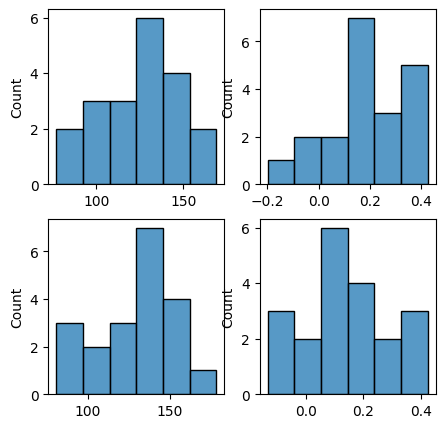

In [51]:
columns_to_cluster = ["ndvi_2018", "ndvi_2019", "ndvi_2020", "ndvi_2021"]
errors = None
for i in range(20):
    new_errors = eval.evaluate_control(5, gedi_unburned_ls_3310, 5000, 200, 
    lambda x, y, z, t: terrain_clustering.match_with_nearest_shot_from_terrain_cluster(x, y, z, t, 10, columns_to_cluster))
    if errors is None:
        errors = new_errors
    else:
        errors = np.vstack((errors, new_errors))

print_errors(errors)
plot_errors(errors)

Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
8
Enter clusteing knn
9
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
9
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
9
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
9
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
8
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
9
Enter clusteing knn
10
Enter clusteing knn
7
Enter clusteing knn
10
Enter clusteing knn
9
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
9
Enter clusteing knn
9
Enter clusteing knn
10
Enter clusteing knn
9
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
10


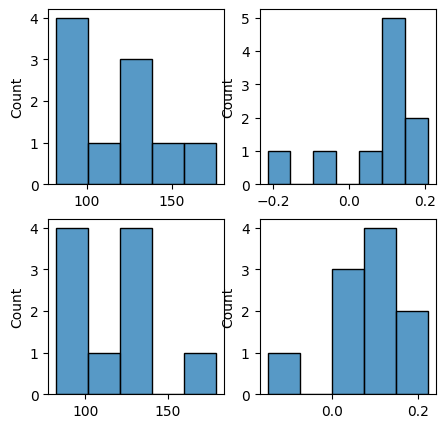

In [53]:
columns_to_cluster = ["ndvi_2018", "ndvi_2019", "ndvi_2020", "ndvi_2021"]
errors = None
for i in range(10):
    new_errors = eval.evaluate_control(5, gedi_unburned_ls_3310, 3000, 200, 
    lambda x, y, z, t: terrain_clustering.match_with_nearest_shot_from_terrain_cluster(x, y, z, t, 10, columns_to_cluster))
    if errors is None:
        errors = new_errors
    else:
        errors = np.vstack((errors, new_errors))

print_errors(errors)
plot_errors(errors)

## Evaluate Algo 4 - terrain clustering

Enter clusteing knn
9
Enter clusteing knn
9
Enter clusteing knn
9
Enter clusteing knn
10
Enter clusteing knn
6
Enter clusteing knn
9
Enter clusteing knn
7
Enter clusteing knn
3
Enter clusteing knn
10
Enter clusteing knn
6
Enter clusteing knn
10
Enter clusteing knn
6
Enter clusteing knn
8
Enter clusteing knn
6
Enter clusteing knn
9
Enter clusteing knn
9
Enter clusteing knn
10
Enter clusteing knn
6
Enter clusteing knn
10
Enter clusteing knn
9
Enter clusteing knn
8
Enter clusteing knn
5
Enter clusteing knn
9
Enter clusteing knn
8
Enter clusteing knn
6
Enter clusteing knn
8
Enter clusteing knn
9
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
7
Enter clusteing knn
10
Enter clusteing knn
9
Enter clusteing knn
8
Enter clusteing knn
5
Enter clusteing knn
6
Enter clusteing knn
9
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
9
Enter clusteing knn
6
Enter clusteing knn
4
Enter clusteing knn
7
Enter clusteing knn
7
Enter clusteing knn
10
Enter clusteing knn
1

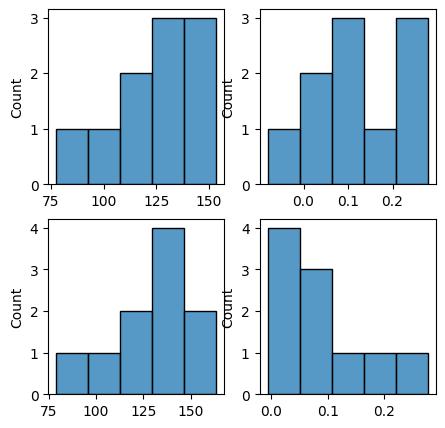

In [260]:
errors = None
columns_to_cluster = ["soil", "aspect", "elevation", "slope"]
for i in range(10):
    new_errors = eval.evaluate_control(5, gedi_unburned_3310, 5000, 200, 
    lambda x, y, z, t: terrain_clustering.match_with_nearest_shot_from_terrain_cluster(x, y, z, t, 10, columns_to_cluster))
    if errors is None:
        errors = new_errors
    else:
        errors = np.vstack((errors, new_errors))

print_errors(errors)
plot_errors(errors)

Enter clusteing knn
4
Enter clusteing knn
6
Enter clusteing knn
9
Enter clusteing knn
9
Enter clusteing knn
7
Enter clusteing knn
5
Enter clusteing knn
8
Enter clusteing knn
7
Enter clusteing knn
5
Enter clusteing knn
8
Enter clusteing knn
8
Enter clusteing knn
7
Enter clusteing knn
8
Enter clusteing knn
7
Enter clusteing knn
9
Enter clusteing knn
10
Enter clusteing knn
3
Enter clusteing knn
4
Enter clusteing knn
6
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
9
Enter clusteing knn
4
Enter clusteing knn
7
Enter clusteing knn
4
Enter clusteing knn
9
Enter clusteing knn
8
Enter clusteing knn
10
Enter clusteing knn
7
Enter clusteing knn
8
Enter clusteing knn
8
Enter clusteing knn
6
Enter clusteing knn
7
Enter clusteing knn
5
Enter clusteing knn
9
Enter clusteing knn
8
Enter clusteing knn
7
Enter clusteing knn
4
Enter clusteing knn
4
Enter clusteing knn
6
Enter clusteing knn
6
Enter clusteing knn
6
Enter clusteing knn
6
Enter clusteing knn
6
Enter

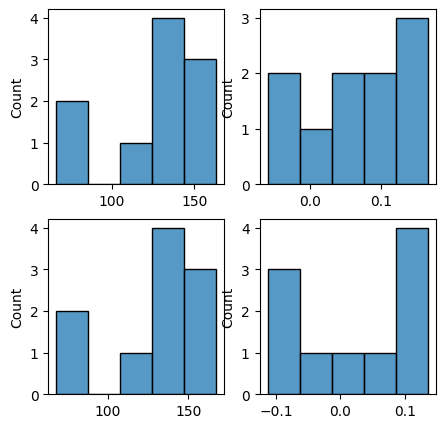

In [261]:
errors = None
columns_to_cluster = ["elevation", "slope"]
for i in range(10):
    new_errors = eval.evaluate_control(5, gedi_unburned_3310, 5000, 200, 
    lambda x, y, z, t: terrain_clustering.match_with_nearest_shot_from_terrain_cluster(x, y, z, t, 10, columns_to_cluster))
    if errors is None:
        errors = new_errors
    else:
        errors = np.vstack((errors, new_errors))

print_errors(errors)
plot_errors(errors)

Enter clusteing knn
9
Enter clusteing knn
9
Enter clusteing knn
5
Enter clusteing knn
5
Enter clusteing knn
9
Enter clusteing knn
6
Enter clusteing knn
4
Enter clusteing knn
9
Enter clusteing knn
8
Enter clusteing knn
9
Enter clusteing knn
10
Enter clusteing knn
4
Enter clusteing knn
10
Enter clusteing knn
9
Enter clusteing knn
4
Enter clusteing knn
6
Enter clusteing knn
10
Enter clusteing knn
8
Enter clusteing knn
6
Enter clusteing knn
10
Enter clusteing knn
5
Enter clusteing knn
9
Enter clusteing knn
7
Enter clusteing knn
6
Enter clusteing knn
9
Enter clusteing knn
7
Enter clusteing knn
10
Enter clusteing knn
9
Enter clusteing knn
8
Enter clusteing knn
9
Enter clusteing knn
8
Enter clusteing knn
10
Enter clusteing knn
6
Enter clusteing knn
10
Enter clusteing knn
8
Enter clusteing knn
5
Enter clusteing knn
6
Enter clusteing knn
3
Enter clusteing knn
5
Enter clusteing knn
10
Enter clusteing knn
9
Enter clusteing knn
10
Enter clusteing knn
7
Enter clusteing knn
9
Enter clusteing knn
8
E

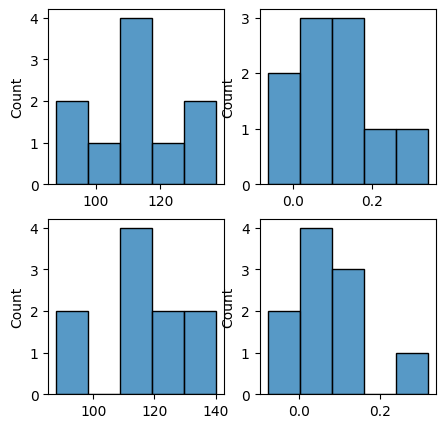

In [267]:
errors = None
columns_to_cluster = ["elevation", "slope"]
for i in range(10):
    new_errors = eval.evaluate_control(5, gedi_unburned_3310, 3000, 100, 
    lambda x, y, z, t: terrain_clustering.match_with_nearest_shot_from_terrain_cluster(x, y, z, t, 10, columns_to_cluster))
    if errors is None:
        errors = new_errors
    else:
        errors = np.vstack((errors, new_errors))

print_errors(errors)
plot_errors(errors)

## Evaluate Algo 3 - nearest shots

In [175]:
errors = None
for i in range(10):
    new_errors = eval.evaluate_control(5, gedi_unburned_3310, 5000, 200, nearest.match_with_nearest_shot_per_pixel)
    if errors is None:
        errors = new_errors
    else:
        errors = np.vstack((errors, new_errors))

print_errors(errors)

Mean Errors:
114.24959233780596
0.10871262293453102
Median Errors:
115.87559689033904
0.0861257890039008


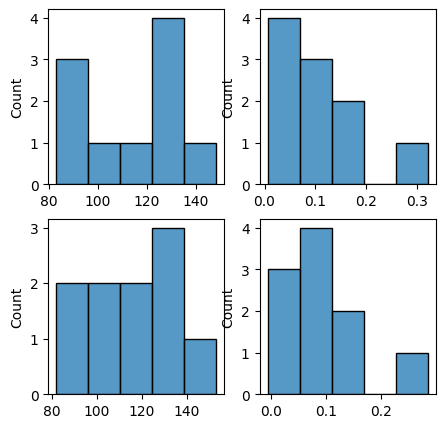

In [183]:
plot_errors(errors)

Mean Errors:
127.35195965240663
0.22135647579748982
Median Errors:
130.1541485026374
0.1861530549486341


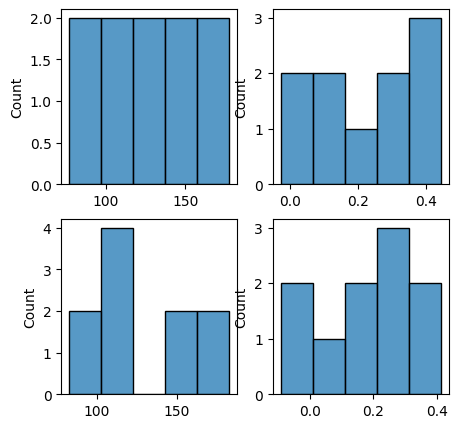

In [184]:
errors = None
for i in range(10):
    new_errors = eval.evaluate_control(5, gedi_unburned_3310, 2000, 100, nearest.match_with_nearest_shot_per_pixel)
    if errors is None:
        errors = new_errors
    else:
        errors = np.vstack((errors, new_errors))

print_errors(errors)
plot_errors(errors)

Mean Errors:
139.37776335844677
0.041196568814547474
Median Errors:
142.7791652999106
-0.002457568070915217


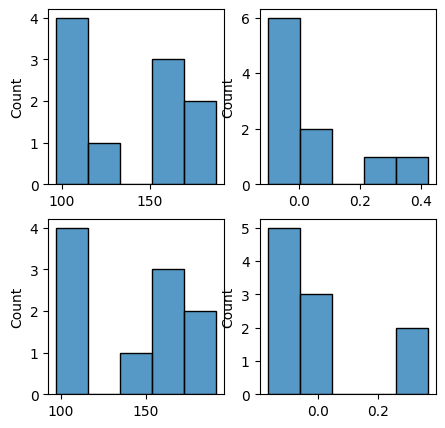

In [185]:
errors = None
for i in range(10):
    new_errors = eval.evaluate_control(5, gedi_unburned_3310, 2000, 100, nearest.match_with_nearest_shot_per_pixel)
    if errors is None:
        errors = new_errors
    else:
        errors = np.vstack((errors, new_errors))

print_errors(errors)
plot_errors(errors)

## Evaluate Algo 2 - match_with_random_shots_per_pixel

In [169]:
errors = None
for i in range(10):
    new_errors = eval.evaluate_control(5, gedi_unburned_3310, 5000, 200, random_control.match_with_random_shots_per_pixel)
    if errors is None:
        errors = new_errors
    else:
        errors = np.vstack((errors, new_errors))

print_errors(errors)

Mean Errors:
108.13336450459258
0.08582488591688582
Median Errors:
111.49580281073777
0.04049863218766646


In [172]:
errors = None
for i in range(10):
    new_errors = eval.evaluate_control(5, gedi_unburned_3310, 3000, 100, random_control.match_with_random_shots_per_pixel)
    if errors is None:
        errors = new_errors
    else:
        errors = np.vstack((errors, new_errors))

print_errors(errors)

Mean Errors:
118.37609054595907
0.09644992798876453
Median Errors:
120.92145345913511
0.05586549547988205


## Evaluate Algo 1 - match_with_random_shots_per_fire

In [9]:
errors = None
for i in range(50):
    new_errors = eval.evaluate_control(5, gedi_unburned_3310, 5000, 200, random_control.match_with_random_shots_per_fire)
    if errors is None:
        errors = new_errors
    else:
        errors = np.vstack((errors, new_errors))

print_errors(errors)

Mean Errors:
121.84230434312711
0.08586638620572383
Median Errors:
123.84304131035877
0.06597637883775011


In [11]:
errors = None
for i in range(50):
    new_errors = eval.evaluate_control(5, gedi_unburned_3310, 3000, 200, random_control.match_with_random_shots_per_fire)
    if errors is None:
        errors = new_errors
    else:
        errors = np.vstack((errors, new_errors))

print_errors(errors)

Mean Errors:
122.56211407911127
0.11797733279899275
Median Errors:
124.25220955298742
0.0951814292901827


In [12]:
errors = None
for i in range(50):
    new_errors = eval.evaluate_control(5, gedi_unburned_3310, 1000, 200, random_control.match_with_random_shots_per_fire)
    if errors is None:
        errors = new_errors
    else:
        errors = np.vstack((errors, new_errors))

print_errors(errors)

ValueError: Input contains NaN.

In [155]:
errors = None
for i in range(50):
    new_errors = eval.evaluate_control(5, gedi_unburned_3310, 1000, 500, random_control.match_with_random_shots_per_fire)
    if errors is None:
        errors = new_errors
    else:
        errors = np.vstack((errors, new_errors))

errors_1000_500 = errors

In [157]:
print("Mean Errors:")
print(errors_1000_500[:, 0].mean())
print(errors_1000_500[:, 1].mean())

print("Median Errors:")
print(errors_1000_500[:, 2].mean())
print(errors_1000_500[:, 3].mean())

Mean Errors:
118.12643763782195
0.15264078390390792
Median Errors:
120.52283470711403
0.12318618204494199


In [161]:
errors = None
for i in range(50):
    new_errors = eval.evaluate_control(5, gedi_unburned_3310, 1000, 5000, random_control.match_with_random_shots_per_fire)
    if errors is None:
        errors = new_errors
    else:
        errors = np.vstack((errors, new_errors))

errors_1000_5000 = errors

In [163]:
print("Mean Errors:")
print(errors_1000_5000[:, 0].mean())
print(errors_1000_5000[:, 1].mean())

print("Median Errors:")
print(errors_1000_5000[:, 2].mean())
print(errors_1000_5000[:, 3].mean())

Mean Errors:
121.64401967370915
0.11415161942434562
Median Errors:
123.59513797533573
0.08574878900678319


<Axes: ylabel='Count'>

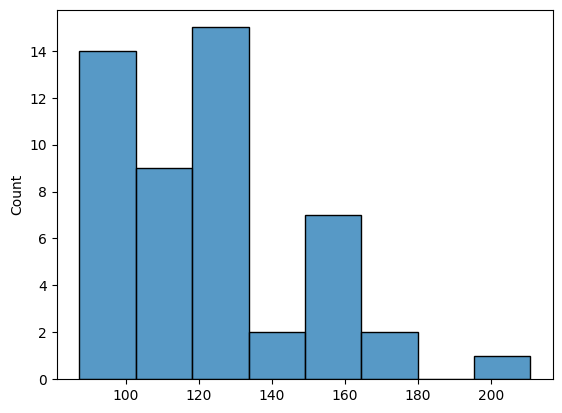

In [142]:
sns.histplot(errors_5000_200[:, 2])